#Permutation Testing and Statistical Power
This project examines the impact of different fee structures—Upfront Fees (UF) versus Back-End Fees (BF)—on consumer purchase behavior for an online travel company, inspired by real-world scenarios from companies like Airbnb or Booking.com. Through a simulated experiment, I analyzed how transitioning to BF might influence the likelihood of a user completing a purchase, employing permutation tests and power analysis to verify the findings.

##Analysis Details

###Data Simulation and Initial Analysis

I created a simulated dataset of 1,000 visits to the travel site, assigning each visit a treatment or control status with equal probability. I modeled consumer purchase behavior based on a 7% baseline probability in the UF group, assuming a modest 1.5 percentage point increase in purchase probability when BF fees were applied. Using this data, I estimated the Average Treatment Effect (ATE) to assess the BF treatment’s influence on purchasing behavior.

###Permutation Testing

To evaluate the ATE rigorously, I used permutation tests under the sharp null hypothesis (i.e., no treatment effect). For each permutation, I randomly shuffled treatment assignments and recalculated the purchase probabilities, allowing me to compare the observed ATE with distribution under the null. I computed p-values for the permutation test and repeated the process 100 times to ensure robust results.

###Simulating Statistical Power

Understanding the statistical power of my experiment was essential to assess its reliability. By wrapping the permutation test in a function, I performed repeated tests to estimate the statistical power, using various sample sizes (e.g., 100, 1,000, 2,000, up to 25,000) and plotting sample size against power to observe its impact. I also explored the minimum detectable effect size at a sample size of 1,000, incrementally adjusting effect sizes from 1 to 8 percentage points to identify the minimal effect required to achieve 80% power.

###Comparison with Proportion Z-Tests

To supplement the permutation analysis, I applied a proportion z-test to test for significance in the ATE, providing a statistical baseline for comparison. I calculated statistical power for this test using the travel site's purchase probability as a Bernoulli variable, analyzing the variance and average effect across treatment groups. This allowed me to evaluate the experiment’s power at 5% significance and estimate the minimum population size needed to achieve 80% power.



In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def gen_data (n, p_treated, p_purchase, treatment_effect ):

    data_dict= {}

    data_dict["visit_ID"] = pd.Series ([ i for i in range(0,n)])

    df = pd.DataFrame(data_dict)


    df["BF"] = np.random.choice([0,1], p=[1- p_treated, p_treated], size=n)

    df["purchase"]=0

    df.purchase[df.BF==0]= np.random.choice([0,1], p=[1- p_purchase ,p_purchase],size = len(df[df.BF==0]))

    p_purchase_t = p_purchase + treatment_effect
    df.purchase[df.BF==1]= np.random.choice([0,1], p=[1- p_purchase_t,p_purchase_t],size = len(df[df.BF==1]))
    return df

df = gen_data (n=1000,  p_treated = 0.5, p_purchase = 0.07, treatment_effect = 0.015 )


In [ ]:
p_purchase_UF = df.loc[df['BF'] == 0]['purchase'].mean()
p_purchase_BF = df.loc[df['BF'] == 1]['purchase'].mean()

ate = p_purchase_BF - p_purchase_UF

print(f"Purchase Probability for UF: {p_purchase_UF}")
print(f"Purchase Probability for BF: {p_purchase_BF}")
print(f"Estimated Average Treatment Effect (ATE): {ate}")

Purchase Probability for UF: 0.07156673114119923
Purchase Probability for BF: 0.07867494824016563
Estimated Average Treatment Effect (ATE): 0.0071082170989664045


In [ ]:
df['shuffle_BF'] = np.random.choice([0, 1], p=[0.5,0.5], size=len(df))

p_purchase_UF_shuffle = df[df['shuffle_BF'] == 0]['purchase'].mean()
p_purchase_BF_shuffle = df[df['shuffle_BF'] == 1]['purchase'].mean()

ate_shuffle = p_purchase_BF_shuffle - p_purchase_UF_shuffle

print(f"Simulated Purchase Probability for UF (shuffled): {p_purchase_UF_shuffle}")
print(f"Simulated Purchase Probability for BF (shuffled): {p_purchase_BF_shuffle}")
print(f"Estimated Treatment Effect under Null (shuffled): {ate_shuffle}")

Simulated Purchase Probability for UF (shuffled): 0.06679389312977099
Simulated Purchase Probability for BF (shuffled): 0.08403361344537816
Estimated Treatment Effect under Null (shuffled): 0.017239720315607165


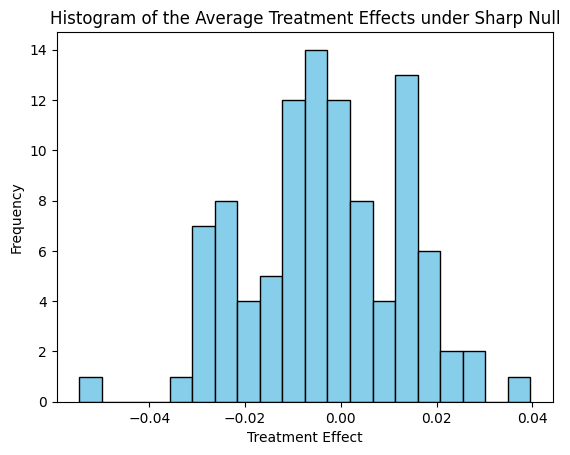

Mean ATE (Shuffled): -0.003302023955978558
Min ATE (Shuffled): -0.05460087361397782
Max ATE (Shuffled): 0.039610140195890146


In [ ]:
ate_shuffled_list = []

for _ in range(100):
    df['shuffle_BF'] = np.random.choice([0, 1], p=[0.5,0.5], size=len(df))

    p_purchase_UF_shuffle = df[df['shuffle_BF'] == 0]['purchase'].mean()
    p_purchase_BF_shuffle = df[df['shuffle_BF'] == 1]['purchase'].mean()

    ate_shuffle = p_purchase_BF_shuffle - p_purchase_UF_shuffle
    ate_shuffled_list.append(ate_shuffle)

plt.hist(ate_shuffled_list, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of the Average Treatment Effects under Sharp Null")
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

mean_ate_shuffle = np.mean(ate_shuffled_list)
min_ate_shuffle = np.min(ate_shuffled_list)
max_ate_shuffle = np.max(ate_shuffled_list)

print(f"Mean ATE (Shuffled): {mean_ate_shuffle}")
print(f"Min ATE (Shuffled): {min_ate_shuffle}")
print(f"Max ATE (Shuffled): {max_ate_shuffle}")

In [ ]:
observed_ate = ate
p_value = np.mean([abs(ate_shuffle) >= abs(observed_ate) for ate_shuffle in ate_shuffled_list])

print(f"P-value: {p_value}")

reject_null = p_value < 0.05
print(f"Reject the null hypothesis at 5% significance level: {reject_null}")

P-value: 0.67
Reject the null hypothesis at 5% significance level: False


Since the treatment effect is present and we fail to reject the null hypothesis so it relates to the confusion matrix through a false negative as the model predicts negative when the true class is positive and it fails to detect an effect when it exists.


In [ ]:
def sim_perm_test(n, p_treated, p_purchase, treatment_effect):

    df = gen_data(n, p_treated, p_purchase, treatment_effect)

    p_purchase_UF = df[df['BF'] == 0]['purchase'].mean()
    p_purchase_BF = df[df['BF'] == 1]['purchase'].mean()
    observed_ate = p_purchase_BF - p_purchase_UF

    ate_shuffled_list = []
    for _ in range(100):
        df['shuffle_BF'] = np.random.choice([0, 1], p=[0.5,0.5], size=len(df))

        p_purchase_UF_shuffle = df[df['shuffle_BF'] == 0]['purchase'].mean()
        p_purchase_BF_shuffle = df[df['shuffle_BF'] == 1]['purchase'].mean()

        ate_shuffle = p_purchase_BF_shuffle - p_purchase_UF_shuffle
        ate_shuffled_list.append(ate_shuffle)

    p_value = np.mean([abs(ate_shuffle) >= abs(observed_ate) for ate_shuffle in ate_shuffled_list])


    return p_value

p_value_test = sim_perm_test(n=1000, p_treated=0.5, p_purchase=0.07, treatment_effect=0.015)
print(f"Estimated p-value: {p_value_test}")

Estimated p-value: 0.08


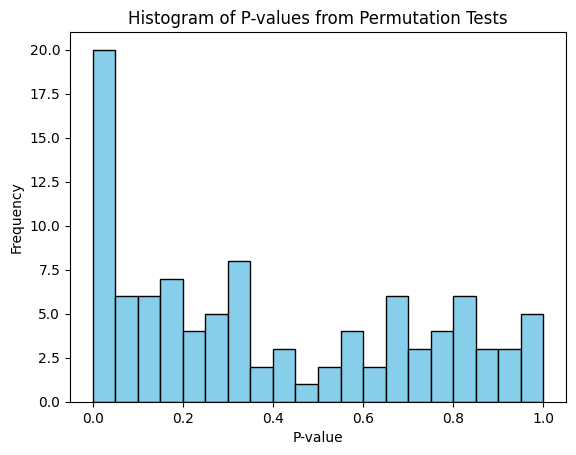

We reject the null hypothesis at a 5% significance level 20.0% of times


In [ ]:
n_simulations = 100
p_values = []

for _ in range(n_simulations):
    p_val = sim_perm_test(n=1000, p_treated=0.5, p_purchase=0.07, treatment_effect=0.015)
    p_values.append(p_val)

rejections = np.mean([p_val < 0.05 for p_val in p_values])

plt.hist(p_values, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of P-values from Permutation Tests")
plt.xlabel("P-value")
plt.ylabel("Frequency")
plt.show()

print(f"We reject the null hypothesis at a 5% significance level {rejections * 100}% of times")

Statistical power can be measured by the percentage of times we reject the null hypothesis at a 5% significance level, which is 20%.

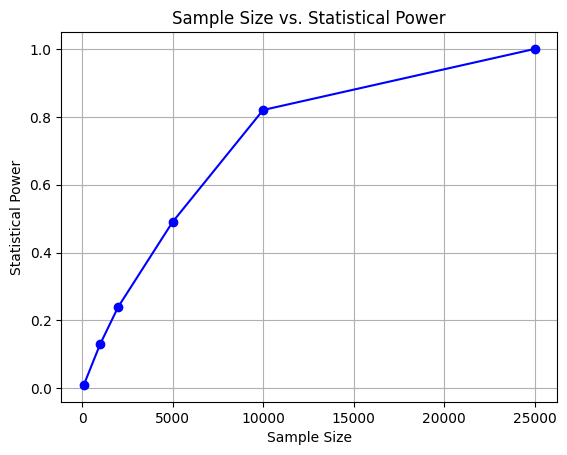

First sample size to exceed 80% power: 10000


In [ ]:
sample_sizes = [100, 1000, 2000, 5000, 10000, 25000]
power_results = []

for n in sample_sizes:
    p_values = [sim_perm_test(n, 0.5, 0.07, 0.015) for _ in range(n_simulations)]
    power = np.mean([p_val < 0.05 for p_val in p_values])
    power_results.append(power)

plt.plot(sample_sizes, power_results, marker='o', linestyle='-', color='b')
plt.title('Sample Size vs. Statistical Power')
plt.xlabel('Sample Size')
plt.ylabel('Statistical Power')
plt.grid(True)
plt.show()

for i, power in enumerate(power_results):
    if power >= 0.8:
        print(f"First sample size to exceed 80% power: {sample_sizes[i]}")
        break

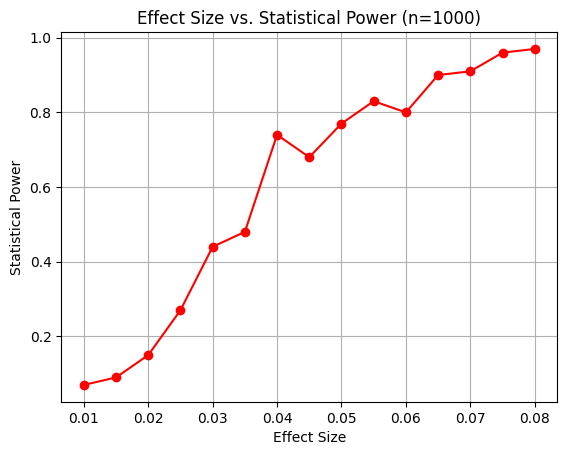

Minimum detectable effect size for 80% power: 0.05499999999999999


In [ ]:
effect_sizes = np.arange(0.01, 0.08, 0.005)
power_results_effect_size = []

for effect_size in effect_sizes:
    p_values = [sim_perm_test(1000, 0.5, 0.07, effect_size) for _ in range(n_simulations)]
    power = np.mean([p_val < 0.05 for p_val in p_values])
    power_results_effect_size.append(power)

plt.plot(effect_sizes, power_results_effect_size, marker='o', linestyle='-', color='r')
plt.title('Effect Size vs. Statistical Power (n=1000)')
plt.xlabel('Effect Size')
plt.ylabel('Statistical Power')
plt.grid(True)
plt.show()

for i, power in enumerate(power_results_effect_size):
    if power >= 0.8:
        print(f"Minimum detectable effect size for 80% power: {effect_sizes[i]}")
        break

In [ ]:
# Intialiize 3.a

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power
np.random.seed(seed=45)
df = gen_data (n=1000,  p_treated = 0.5, p_purchase = 0.07, treatment_effect = 0.015 )


In [ ]:
p_purchase_UF = df[df['BF'] == 0]['purchase'].mean()  # UF: control group
p_purchase_BF = df[df['BF'] == 1]['purchase'].mean()  # BF: treatment group
observed_ate = p_purchase_BF - p_purchase_UF

print(f"Purchase Probability for UF: {p_purchase_UF}")
print(f"Purchase Probability for BF: {p_purchase_BF}")
print(f"Estimated Average Treatment Effect (ATE): {observed_ate}")

n_UF = df[df['BF'] == 0].shape[0]
n_BF = df[df['BF'] == 1].shape[0]

success_UF = df[df['BF'] == 0]['purchase'].sum()
success_BF = df[df['BF'] == 1]['purchase'].sum()

z_stat, p_value = proportions_ztest([success_UF, success_BF], [n_UF, n_BF])

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

significant = p_value < 0.05
print(f"Is the effect size statistically significant? {significant}")

Purchase Probability for UF: 0.07156673114119923
Purchase Probability for BF: 0.07867494824016563
Estimated Average Treatment Effect (ATE): 0.0071082170989664045
Z-statistic: -0.4264597248821133
P-value: 0.6697728894265225
Is the effect size statistically significant? False


In [ ]:
p_combined = (success_UF + success_BF) / (n_UF + n_BF)  # Overall proportion
std_dev = (p_combined * (1 - p_combined) * (1/n_UF + 1/n_BF))**(1/2)
effect_size = observed_ate / std_dev

power = zt_ind_solve_power(effect_size=effect_size, nobs1=n_UF, alpha=0.05, ratio=n_BF/n_UF, alternative='two-sided')

print(f"Statistical Power: {power}")

min_n_per_cell = zt_ind_solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=n_BF/n_UF, alternative='two-sided')

total_population = 2 * min_n_per_cell

print(f"Minimum population size for 80% power: {total_population}")

Statistical Power: 0.9999991194071186
Minimum population size for 80% power: 178.7036540487333


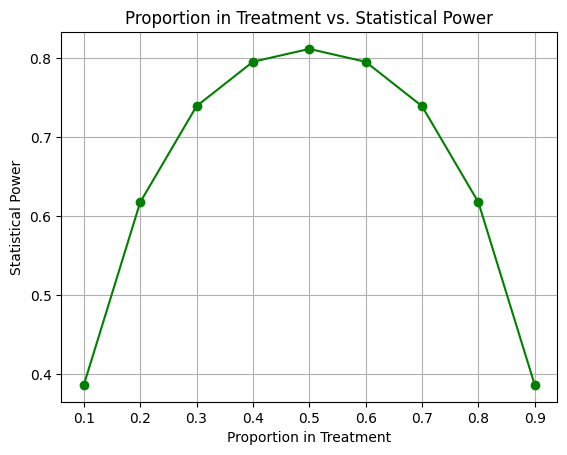

Split that maximizes statistical power: 50.0% in treatment


In [ ]:
splits = np.arange(0.1, 1.0, 0.1)
power_splits = []

for split in splits:
    n_treat = int(total_population * split)
    n_control = int(total_population * (1 - split))

    power = zt_ind_solve_power(effect_size=effect_size, nobs1=n_treat, alpha=0.05, ratio=n_control/n_treat, alternative='two-sided')
    power_splits.append(power)

plt.plot(splits, power_splits, marker='o', linestyle='-', color='g')
plt.title('Proportion in Treatment vs. Statistical Power')
plt.xlabel('Proportion in Treatment')
plt.ylabel('Statistical Power')
plt.grid(True)
plt.show()

max_power_split = splits[np.argmax(power_splits)]
print(f"Split that maximizes statistical power: {max_power_split * 100}% in treatment")